### Importing necessary Libraries

In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard



### Creating dataset

In [2]:
Datadir = os.getcwd()
Datadir = os.path.join(Datadir,"Final_data_flare")
train_data = os.path.join(Datadir,"train")
img_lst = os.listdir(train_data)


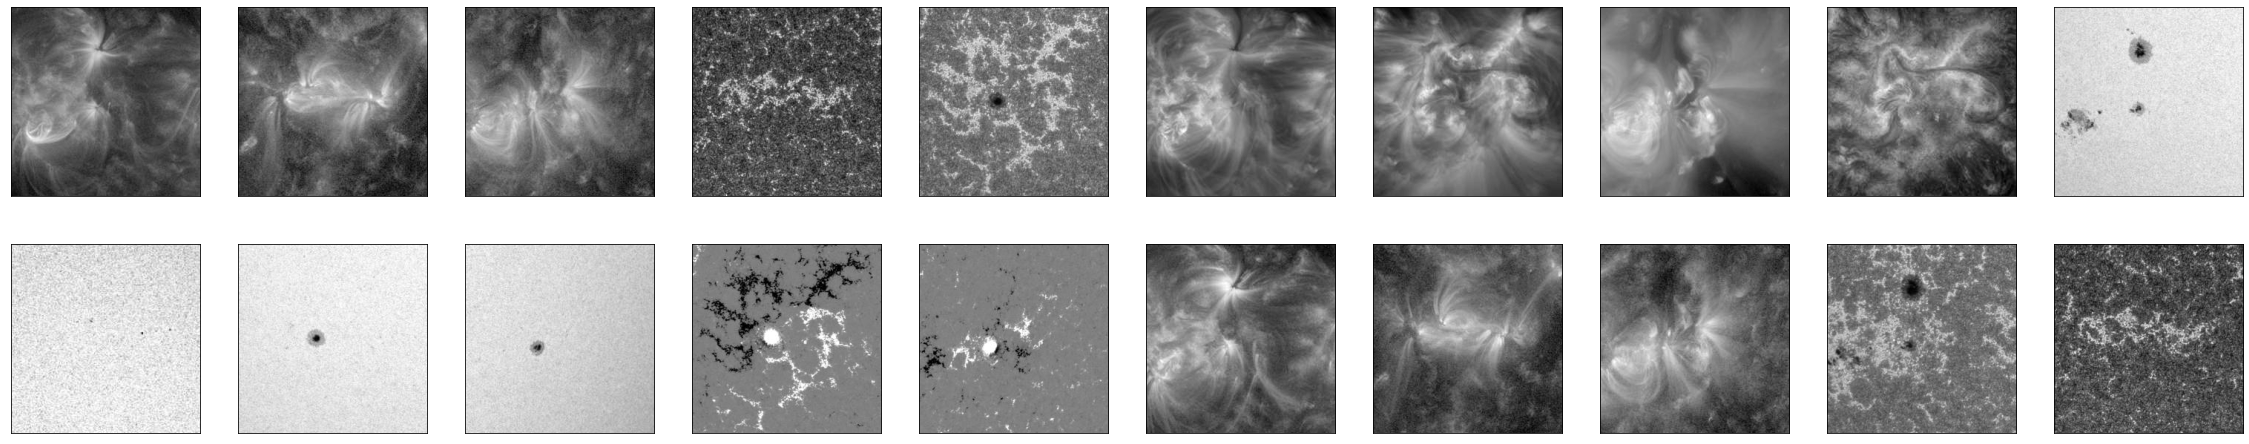

In [3]:
fig = plt.figure(figsize=(40,8))
for img in range(20):
    imgpath = os.path.join(train_data, img_lst[img])
    im = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    ax = fig.add_subplot(2,10, img + 1, xticks = [],yticks =[])
    ax.imshow(im, cmap = "gray")

In [4]:
train_csv = pd.read_csv(os.path.join(Datadir,'train.csv'))
train_csv.head()

,File_name,flare_status
0,2012-01-01T070600__131(132).jpg,1
1,2012-01-01T070600__131(262).jpg,1
2,2012-01-01T070600__131.jpg,1
3,2012-01-01T070600__1700(263).jpg,0
4,2012-01-01T070600__1700(36).jpg,0


### flare_status 0 means "No flare", 1 means "flare"

In [5]:
def create_data(train_csv):
    data=[]
    count=0
    for index, row in train_csv.iterrows():
        img_array=cv2.imread(os.path.join(train_data,row['File_name']),0)
        data.append([img_array, row['flare_status']])
        count+=1
        if count>29999:
            break
    return data
data=create_data(train_csv)

### Checking if the image is mapped to correct label or not

In [6]:
cv2.imshow("img",data[4009][0])
print(data[4009][0].shape)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Label:",data[4009][1])
print("Length of data",len(data))

(256, 256)
Label: 1
Length of data 30000


In [7]:
import random 
random.shuffle(data)

#Extract image and label from data as x & y
X=[i[0] for i in data] #images array
Y=[i[1] for i in data] #label of image 0 or 1

#convert to numpy array
X=np.array(X) 
Y=np.array(Y)


### Checking if the dataset is balanced or not

15103 14897


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([14897. , 14917.6, 14938.2, 14958.8, 14979.4, 15000. , 15020.6,
        15041.2, 15061.8, 15082.4, 15103. ]),
 <BarContainer object of 10 artists>)

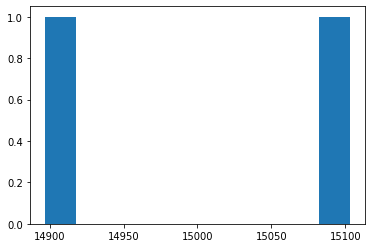

In [8]:
no_flare = 0
flare = 0
for i in Y:
    if i == 0:
        no_flare = no_flare + 1
    else:
        flare = flare + 1
print(no_flare, flare)
lst = [no_flare, flare]
plt.hist(lst)

### Normalizing and reshaping the data

In [9]:
X=X/255.0

In [10]:
print(X.shape)

#Reshape for grayscale 
X=X.reshape((X.shape[0],X.shape[1],X.shape[2],1)) #for grayscale image

print(X.shape)
# print(x[0])

(30000, 256, 256)
(30000, 256, 256, 1)


### Splitting data into train & test splits

In [11]:
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(24000, 256, 256, 1) (24000,)
(6000, 256, 256, 1) (6000,)


In [12]:

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(physical_devices)



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Creating first CNN architecture

In [22]:
# Model configuration
loss_function = sparse_categorical_crossentropy
no_epochs = 30
optimizer = Adam()
verbosity = 1

# Determine shape of the data
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# Define the model architecture
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units = 500, activation='relu'))

model.add(layers.Dense(units = 250, activation='relu'))

model.add(layers.Dense(units = 100, activation='relu'))

model.add(layers.Dense(units = 40, activation='relu'))

model.add(layers.Dense(units = 10, activation='relu'))

model.add(layers.Dense(units = 2, activation = 'softmax'))

model.compile(loss = loss_function, optimizer=optimizer, metrics=['accuracy'])

hist1 = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Train on 19200 samples, validate on 4800 samples
Epoch 1/5
19200/19200 [==============================] - 33s 2ms/sample - loss: 0.0843 - accuracy: 0.9677 - val_loss: 0.0464 - val_accuracy: 0.9850
Epoch 2/5
19200/19200 [==============================] - 32s 2ms/sample - loss: 0.0239 - accuracy: 0.9921 - val_loss: 0.0017 - val_accuracy: 0.9990
Epoch 3/5
19200/19200 [==============================] - 32s 2ms/sample - loss: 0.0787 - accuracy: 0.9801 - val_loss: 0.0057 - val_accuracy: 0.9981
Epoch 4/5
19200/19200 [==============================] - 32s 2ms/sample - loss: 0.0135 - accuracy: 0.9969 - val_loss: 0.0092 - val_accuracy: 0.9977
Epoch 5/5
19200/19200 [==============================] - 32s 2ms/sample - loss: 0.0291 - accuracy: 0.9908 - val_loss: 0.0752 - val_accuracy: 0.9798


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)       

### Saving the model

In [24]:
model.save("models\\My CNN.h5")

### Testing the model

In [26]:

test_loss, test_acc = model2.evaluate(x_test, y_test)
print("test loss : ", test_loss)
print("test accuracy : ", test_acc)
prediction=model2.predict_classes(x_test)

tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
confusion_mat = [[tp,fp], [fn,tn]]
print("Confusion Matrix:\n\t", confusion_mat[0],"\n\t", confusion_mat[1])

print("precision=", precision_score(y_test, prediction))
print("recall=", recall_score(y_test, prediction))
print("f1-score=", f1_score(y_test, prediction))


6000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test loss :  0.07316999558607737
test accuracy :  0.98
Confusion Matrix:
	 [2862, 3] 
	 [117, 3018]
precision= 0.9989528795811519
recall= 0.9607250755287009
f1-score= 0.9794661190965093


In [25]:
model2=tf.keras.models.load_model("models\\My CNN.h5")

### Testing the model on an image

In [27]:
test_img = os.path.join(Datadir,"test")
img_lst = os.listdir(test_img)

def test_in(filepath):
    IMGSIZE = 256
    img = cv2.imread(os.path.join(test_img,filepath), cv2.IMREAD_GRAYSCALE)
    cv2.imshow("image",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    img= img.reshape((1,IMGSIZE,IMGSIZE,1))
    #img_array = cv2.resize(img, (IMGSIZE, IMGSIZE),1)
    #return img_array.reshape(-1, IMGSIZE, IMGSIZE, 1)
    return img

In [28]:
image = test_in(img_lst[5469])
print(image.shape)
image=image/255.0
# pre = np.array([])
# pre.shape
class1= model2.predict_classes(image)
print(class1)

(1, 256, 256, 1)
[1]


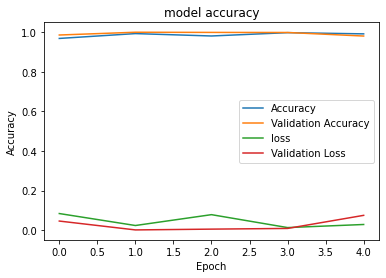

In [29]:
plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history['val_accuracy'])
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Creating second CNN architecture

In [30]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'))

model.add(Conv2D(filters=20, kernel_size = (3,3), strides=(1,1), padding='valid', activation='relu'))
model.add(Conv2D(filters=20, kernel_size = (3,3), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'))

model.add(Flatten())

model.add(Dense(units=84, activation='relu'))

model.add(Dense(units=30, activation='relu'))

model.add(Dense(units=10,activation='relu'))

model.add(Dense(units=2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # can also use categorical crossentropy / sparse categorical crossentropy loss function

hist = model.fit(x_train, y_train, epochs=5, batch_size=100, validation_split=0.2)



Train on 19200 samples, validate on 4800 samples
Epoch 1/5
19200/19200 [==============================] - 29s 1ms/sample - loss: 0.1819 - accuracy: 0.9135 - val_loss: 0.0086 - val_accuracy: 0.9990
Epoch 2/5
19200/19200 [==============================] - 27s 1ms/sample - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0.0032 - val_accuracy: 0.9994
Epoch 3/5
19200/19200 [==============================] - 27s 1ms/sample - loss: 0.0534 - accuracy: 0.9848 - val_loss: 0.0040 - val_accuracy: 0.9994
Epoch 4/5
19200/19200 [==============================] - 27s 1ms/sample - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0079 - val_accuracy: 0.9981
Epoch 5/5
19200/19200 [==============================] - 27s 1ms/sample - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.0037 - val_accuracy: 0.9996


In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 20)      2900      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 123, 123, 20)      3620      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 61, 61, 20)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 59, 59, 32)        5792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 29, 32)       

In [32]:
model.save('CNN_1.h5')

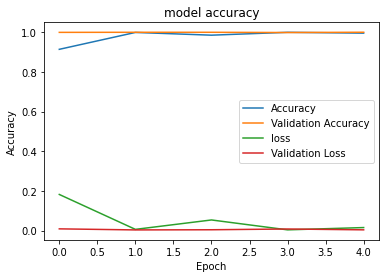

In [33]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [34]:

test_loss, test_acc = model.evaluate(x_test, y_test)
print("test loss : ", test_loss)
print("test accuracy : ", test_acc)
prediction=model.predict_classes(x_test)

tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
confusion_mat = [[tp,fp], [fn,tn]]
print("Confusion Matrix:\n\t", confusion_mat[0],"\n\t", confusion_mat[1])

print("precision = ", precision_score(y_test,prediction))
print("recall = ", recall_score(y_test,prediction))
print("f1-score = ", f1_score(y_test,prediction))


6000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test loss :  0.0036349707871365052
test accuracy :  0.9996667
Confusion Matrix:
	 [2978, 1] 
	 [1, 3020]
precision =  0.9996643168848607
recall =  0.9996643168848607
f1-score =  0.9996643168848607


In [36]:
#confusion_matrix(y_test,prediction)
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3021
           1       1.00      1.00      1.00      2979

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



### Creating third CNN architecture

In [37]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units= 80, activation = 'relu'))

model.add(layers.Dense(units= 20, activation = 'relu'))

model.add(layers.Dense(units= 2, activation = 'softmax'))

model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = tf.keras.optimizers.Adam(),metrics = ['accuracy'])

hist2 = model.fit(x_train, y_train, epochs=6, batch_size = 100,validation_split=0.2)


Train on 19200 samples, validate on 4800 samples
Epoch 1/6
19200/19200 [==============================] - 27s 1ms/sample - loss: 0.1223 - accuracy: 0.9402 - val_loss: 0.0126 - val_accuracy: 0.9956
Epoch 2/6
19200/19200 [==============================] - 26s 1ms/sample - loss: 0.0551 - accuracy: 0.9872 - val_loss: 0.2141 - val_accuracy: 0.9146
Epoch 3/6
19200/19200 [==============================] - 26s 1ms/sample - loss: 0.0371 - accuracy: 0.9888 - val_loss: 0.0081 - val_accuracy: 0.9985
Epoch 4/6
19200/19200 [==============================] - 26s 1ms/sample - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 5/6
19200/19200 [==============================] - 26s 1ms/sample - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0060 - val_accuracy: 0.9994
Epoch 6/6
19200/19200 [==============================] - 26s 1ms/sample - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0491 - val_accuracy: 0.9840


In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)            

In [39]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("test loss : ", test_loss)
print("test accuracy : ", test_acc)
prediction=model.predict_classes(x_test)

tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
confusion_mat = [[tp,fp], [fn,tn]]
print("Confusion Matrix:\n\t", confusion_mat[0],"\n\t", confusion_mat[1])

print("precision = ", precision_score(y_test,prediction))
print("recall = ", recall_score(y_test,prediction))
print("f1-score = ", f1_score(y_test,prediction))

6000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test loss :  0.04564370963256806
test accuracy :  0.98366666
Confusion Matrix:
	 [2882, 1] 
	 [97, 3020]
precision =  0.9996531390912244
recall =  0.967438737831487
f1-score =  0.9832821562606618


In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)            

In [41]:
model.save("CNN_2.h5")

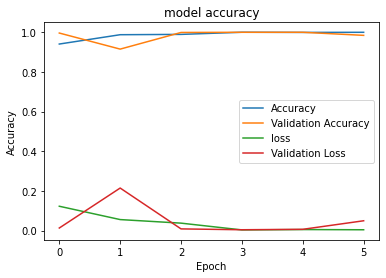

In [42]:
plt.plot(hist2.history["accuracy"])
plt.plot(hist2.history['val_accuracy'])
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()